In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import re
import numpy as np
import capstone2_utilities as c2 

cores = 4

In [2]:
tweets_with_originals = pd.read_csv('tweets_with_originals.csv', parse_dates = ['tweet_created'])

In [3]:
tweets_with_originals['text_clean'] = tweets_with_originals.text_clean.str.replace(r'@(\w+)([\s.,:;!])?', r'\1 ') # remove @s in @mentions

In [4]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import string
#stopwords = stopwords.union(set([i for i in string.punctuation])) # remove punctuation
#stopwords = stopwords.union(set(['AmericanAir', 'United', 'USAirways', 'JetBlue', 'SouthwestAir', 'Delta', 'VirginAmerica']))

In [5]:
tweets_with_originals.loc[55].text_clean

"VirginAmerica hi! i'm so excited about your $99 LGA->DAL deal- but i've been trying 2 book since last week & the page never loads. thx!"

# TF-IDF to identify additional stopwords 

Using TF-IDF, we'll look for additional stopwords 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10)
tweet_input = tweets_with_originals.text_clean
# maybe try to take out numbers, prices 
tweet_input=tweet_input.str.replace(r" (\d|\W)+","") # remove digits, nonword things
T = tfidf_vectorizer.fit_transform(tweet_input) # these are our features

In [7]:
idf_df = pd.DataFrame(index = tfidf_vectorizer.get_feature_names())
idf_df['idf_vals']= tfidf_vectorizer.idf_
idf_df.describe()

,idf_vals
count,1628.000000
mean,7.120723
std,0.958025
min,2.421465
25%,6.609403
50%,7.360819
75%,7.871644
max,8.181799


The minimum inverse document frequency is not so low. For our first pass I won't add any stopwords based on IDF values. 

We can use this array of tfidf vectors as input features... for testing purposes we'll also allow 2-grams and 3-grams to see if this improves the result. 

In [8]:
tf2_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10, ngram_range = (1,2))
tf3_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10, ngram_range = (1,3))
T_2 = tf2_vectorizer.fit_transform(tweet_input) 
T_3 = tf3_vectorizer.fit_transform(tweet_input)

tfidf_input_mats = [T, T_2, T_3]

# Word2Vec Model 

First we'll train a word2vec model on our tweets and see what sorts of words are grouped together. 

In [9]:
from nltk.tokenize.casual import TweetTokenizer
from gensim.models.word2vec import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
cores = 4 # depends on how many cores you have...

tokenizer = TweetTokenizer(preserve_case=False)
tokenized_input = [tokenizer.tokenize(tweet) for tweet in tweet_input.values]
tokenized_input = [[word for word in tweet if word not in string.punctuation] for tweet in tokenized_input]
model_word2vec = Word2Vec(tokenized_input, window=5, min_count=10, workers=cores) # build vocabulary

model_word2vec.train(tokenized_input, total_examples=len(tokenized_input), epochs=10)
model_word2vec.save('airlinetweet_word2vec.model')

The results look ok, airlines are associated with other airlines...

In [10]:
model_word2vec.wv.most_similar('united')

/conda/envs/nlp/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('jetblue', 0.8768449425697327),
 ('americanair', 0.8266503810882568),
 ('southwestair', 0.8174761533737183),
 ('usairways', 0.780196487903595),
 ('virginamerica', 0.6700769662857056),
 ('mind', 0.4904249310493469),
 ('guess', 0.4821639657020569),
 ('god', 0.48063167929649353),
 ('that', 0.4727621376514435),
 ('report', 0.46082931756973267)]

In [11]:
model_word2vec.wv.most_similar('usairways')

[('americanair', 0.8229646682739258),
 ('united', 0.7801964282989502),
 ('jetblue', 0.7441019415855408),
 ('southwestair', 0.7262108325958252),
 ('mind', 0.4514126181602478),
 ('virginamerica', 0.4489743709564209),
 ('already', 0.42902764678001404),
 ('guess', 0.41906771063804626),
 ('god', 0.4001840353012085),
 ('worries', 0.39466479420661926)]

And TSA with security check type things

In [12]:
model_word2vec.wv.most_similar('tsa')

[('pre', 0.8713743090629578),
 ('name', 0.7713217735290527),
 ('receipt', 0.7228171825408936),
 ('stuff', 0.718065619468689),
 ('fare', 0.7146759033203125),
 ('passenger', 0.707695484161377),
 ('file', 0.7035782337188721),
 ('request', 0.6978631019592285),
 ('reservation', 0.697336733341217),
 ('res', 0.6936311721801758)]

## Doc2Vec Model

Doc2Vec learns "document" vectors instead of word vectors. We view each tweet as a document

In [13]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
sentiment_tweets_docs = [TaggedDocument(tokenized_input[i], [str(tweets_with_originals.tweet_id.iloc[i])]) for i in range(tweet_input.shape[0])]

In [14]:
model_doc2vec = Doc2Vec(dm=1, vector_size=300, hs=1, window=5,
                        min_count=10, sample=0, epochs=20, alpha = .4, 
                        workers=cores, dbow_words = 1)
model_doc2vec.build_vocab(sentiment_tweets_docs)
model_doc2vec.train(sentiment_tweets_docs, total_examples = len(sentiment_tweets_docs), epochs = 20)
model_doc2vec.save('airlinetweet_doc2vec.model')

In [15]:
model_doc2vec.wv.most_similar('late')

[('its', 0.8927080631256104),
 ('refuse', 0.8921086192131042),
 ('supposed', 0.88742595911026),
 ('nyc', 0.8818486928939819),
 ('gave', 0.8734860420227051),
 ('directly', 0.8725155591964722),
 ('wont', 0.8711974024772644),
 ('empty', 0.8696985244750977),
 ('hr', 0.8695963621139526),
 ('✌', 0.8670365810394287)]

In [16]:
model_doc2vec.wv.most_similar('delay')

[('sadly', 0.9078196287155151),
 ('attendant', 0.8967957496643066),
 ("aren't", 0.8942638635635376),
 ('value', 0.8760038018226624),
 ('security', 0.8725130558013916),
 ('tickets', 0.8679995536804199),
 ('happen', 0.8668830394744873),
 ('refund', 0.8644219636917114),
 ('these', 0.8557482957839966),
 ('the', 0.8526627421379089)]

In [17]:
model_doc2vec.wv.most_similar('tsa')

[('know', 0.8749268651008606),
 ('cost', 0.8416961431503296),
 ('helped', 0.8233813047409058),
 ('b4', 0.8098344206809998),
 ('own', 0.8066888451576233),
 ('extra', 0.8050414323806763),
 ('advantage', 0.8027144074440002),
 ('i', 0.7969229221343994),
 ("let's", 0.7958469390869141),
 ('got', 0.7866212725639343)]

In [18]:
model_doc2vec.docvecs.most_similar('570085644015419393')

[('570247763704868864', 0.9152392148971558),
 ('568997044406374400', 0.8972954750061035),
 ('569918327767879680', 0.8908112645149231),
 ('568873459901702145', 0.890682578086853),
 ('568200350697717760', 0.8859471082687378),
 ('567782645975625729', 0.8823562264442444),
 ('570177752973885440', 0.8798604011535645),
 ('570138826032713729', 0.8785470128059387),
 ('570251909447192577', 0.8723245859146118),
 ('568086073814827008', 0.8720375299453735)]

The following tweets are quite similar according to the model: 

In [19]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 570085644015419393]['text_clean'].values

array(["USAirways  A few years ago I lost over 50,00 miles bc I was physically unable to fly during the period.  I submitted a doctor's note."],
      dtype=object)

In [20]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 570274362936266752]['text_clean'].values

array(['SouthwestAir Teyana Taylor Performing #MedusaFridays 2[.] 27 Free Till11   #TheMenOfBusiness'],
      dtype=object)

In [21]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 569734884396302338]['text_clean'].values

array(['USAirways #usairways lost a passenger today for not upholding their promise of excellent customer service!!'],
      dtype=object)

In [22]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 570277054635057153]['text_clean'].values

array(['jetblue having trouble signing in to TrueBlue today, despite right credentials. getting "We are not able to sign you in" msg.'],
      dtype=object)

They are at least all negative sentiment tweets, so hopefully we're heading in the right direction. 

### TODO: different models with different hyperparameters, methods (DBOW vs not etc) as a list, test train split on all of these to test model (better accuracy -> better model (ish) 

In [23]:
model_2_doc2vec = Doc2Vec(dm=0, vector_size=300, negative=5, window=5,
                        min_count=10, sample=1e-5, epochs=20, 
                        workers=cores, dbow_words = 1)
model_2_doc2vec.build_vocab(sentiment_tweets_docs)
model_2_doc2vec.train(sentiment_tweets_docs, total_examples = len(sentiment_tweets_docs), epochs = 20)
model_2_doc2vec.save('airlinetweet_doc2vec_2.model')

In [24]:
model_2_doc2vec.wv.most_similar('late')

[('march', 0.9995496869087219),
 ('fam', 0.9995301961898804),
 ('welcome', 0.9995203614234924),
 ('rewards', 0.9995168447494507),
 ('✈', 0.999514639377594),
 ('mine', 0.9995139837265015),
 ('clothes', 0.9995129704475403),
 ('social', 0.9995110034942627),
 ('flightn', 0.9995100498199463),
 ('enter', 0.9995092749595642)]

In [25]:
model_3_doc2vec = Doc2Vec(dm=0, vector_size=300, negative=5, window=5,
                        min_count=10, sample=1e-5, epochs=20, 
                        workers=cores, dbow_words = 1)
model_3_doc2vec.build_vocab(sentiment_tweets_docs)
model_3_doc2vec.train(sentiment_tweets_docs, total_examples = len(sentiment_tweets_docs), epochs = 20)
model_3_doc2vec.save('airlinetweet_doc2vec_3.model')

In [26]:
model_3_doc2vec.wv.most_similar('late')

[('fam', 0.9995274543762207),
 ('alone', 0.9995249509811401),
 ('between', 0.9995194673538208),
 ('flightn', 0.999518632888794),
 ('city', 0.9995133876800537),
 ('msg', 0.9995127320289612),
 ('wont', 0.9995114803314209),
 ('welcome', 0.9995113611221313),
 ('social', 0.9995094537734985),
 ('shitty', 0.9995070695877075)]

In [27]:
doc2vec_models = [model_doc2vec, model_2_doc2vec, model_3_doc2vec]

# Sentiment Analysis

The sentiments in our dataset are highly imbalanced: 

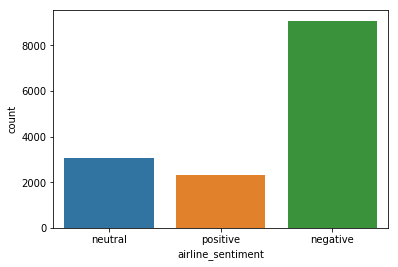

In [28]:
_ = sns.countplot(x = 'airline_sentiment', data = tweets_with_originals)

There are a lot of strategies we could try to rebalance the dataset. The easiest would be oversampling the neutral/positive sentiment tweets. 

In [30]:
# test split with oversampling ... try SMOTE 
from imblearn.over_sampling import SMOTE

y = tweets_with_originals.airline_sentiment.map({'negative': 0, 'neutral':1, 'positive':2})

# test_train split for TFIDF outputs 
tfidf_learning_inputs = []
for M in tfidf_input_mats:
    T_train, T_test, y_train, y_test = train_test_split(T, y, test_size=0.3)
    sm = SMOTE() # smarter upsampling 
    T_train_sm, y_train_sm = sm.fit_sample(T_train, y_train.ravel())
    tfidf_learning_inputs.append([T_train_sm, T_test, y_train_sm, y_test])

In [31]:
# test_train_split for Doc2Vec outputs
#train
tweet_ids = tweets_with_originals.tweet_id.astype(str).values
doc2vec_learning_inputs = []
for model in doc2vec_models: 
    X_train, X_test, y_train, y_test = c2.doc2vec_train_test_split(model, tweet_ids, y)
    sm = SMOTE()
    X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())
    doc2vec_learning_inputs.append([X_train_sm, X_test, y_train_sm, y_test])

We confirm that SMOTE balances the number of training samples in each class... 

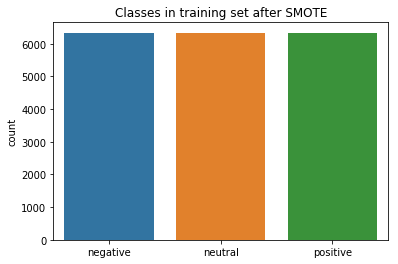

In [32]:
_ = sns.countplot(x = tfidf_learning_inputs[0][2])
_ = plt.title('Classes in training set after SMOTE')
locs, labels = plt.xticks()
_ = plt.xticks(locs, ['negative', 'neutral', 'positive'], )

## Method 1: Logistic Regression

### TF-IDF input sentiment analysis
Basic logistic regression with one-versus-rest (OVR) multiclass scheme. 

In [33]:
from sklearn.linear_model import LogisticRegression

tfidf_log_models = []
for i, ngram_model in enumerate(tfidf_learning_inputs): 
    lr = LogisticRegression(solver = 'lbfgs', multi_class='auto', max_iter = 200)
    lr.fit(ngram_model[0], ngram_model[2])
    print('{}-gram TF-IDF:\t Accuracy {}'.format(i+1,lr.score(ngram_model[1], ngram_model[3])))
    tfidf_log_models.append(lr)

1-gram TF-IDF:	 Accuracy 0.7502879520847731
2-gram TF-IDF:	 Accuracy 0.7403824003685787
3-gram TF-IDF:	 Accuracy 0.75074867542041


### Word2Vec input sentiment analysis

We try the sum of words embedding which is described [here](https://white.ucc.asn.au/publications/White2015SentVecMeaning.pdf). We just take the sum of the word vectors contained in a tweet. 

In [34]:
target_vec = tweets_with_originals.set_index('tweet_id').airline_sentiment.map({'negative': 0, 'neutral':1, 'positive':2})
tokenized_input_ser = pd.Series(tokenized_input, index=tweets_with_originals.tweet_id)

In [53]:
word2vec_sow_inputs = []
for model in doc2vec_models:
    X_train, X_test, y_train, y_test = c2.word2vec_train_test_split(model_word2vec, tokenized_input_ser, target_vec)
    sm = SMOTE() # smarter upsampling 
    X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())
    word2vec_sow_inputs.append([X_train_sm, X_test, y_train_sm, y_test])

In [52]:
word2vec_avg_inputs = []
for model in doc2vec_models:
    X_train, X_test, y_train, y_test = c2.word2vec_train_test_split(model_word2vec, tokenized_input_ser, target_vec, embedding = 'avge')
    sm = SMOTE() # smarter upsampling 
    X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())
    word2vec_avg_inputs.append([X_train_sm, X_test, y_train_sm, y_test])

### Word2vec Sum of words input sentiment analysis 

In [54]:
word2vec_sow_log_models = []
for i, sow_model in enumerate(word2vec_sow_inputs): 
    lr = LogisticRegression(solver = 'lbfgs', multi_class='auto', max_iter = 2000)
    lr.fit(sow_model[0], sow_model[2])
    print('Word2Vec Sum of words Model {}:\t Accuracy {}'.format(i+1,lr.score(sow_model[1], sow_model[3])))
    word2vec_sow_log_models.append(lr)

Word2Vec Sum of words Model 1:	 Accuracy 0.6984565768256162
Word2Vec Sum of words Model 2:	 Accuracy 0.6933886201336098
Word2Vec Sum of words Model 3:	 Accuracy 0.6922368117945173


### Word2vec Avg embedding input sentiment analysis

In [57]:
word2vec_avg_log_models = []
for i, avg_model in enumerate(word2vec_avg_inputs): 
    lr = LogisticRegression(solver = 'lbfgs', multi_class='auto', max_iter = 2000)
    lr.fit(avg_model[0], avg_model[2])
    print('Word2Vec Mean Embedding Model {}:\t Accuracy {}'.format(i+1,lr.score(avg_model[1], avg_model[3])))
    word2vec_avg_log_models.append(lr)

Word2Vec Mean Embedding Model 1:	 Accuracy 0.6998387468325271
Word2Vec Mean Embedding Model 2:	 Accuracy 0.6848652384243262
Word2Vec Mean Embedding Model 3:	 Accuracy 0.6975351301543423


Average and sum of word embeddings for tweets seem to perform comparably: this is in line with what we'd expect from the literature. 

### Doc2Vec input sentiment analysis

In [38]:
doc2vec_log_models = []
for i,model in enumerate(doc2vec_learning_inputs): 
    lr = LogisticRegression(solver='lbfgs', multi_class = 'auto', max_iter = 500)
    lr.fit(model[0], model[2])
    print('Model {}: \t Accuracy {}'.format(i+1, lr.score(model[1], model[3])))
    doc2vec_log_models.append(lr)

/conda/envs/nlp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Model 1: 	 Accuracy 0.2976272748214697
Model 2: 	 Accuracy 0.5215388159410275
Model 3: 	 Accuracy 0.5088689242110113


Performance is poor here: instability was observed in results when training the various Doc2Vec models. I think that we need more training data: the number of tweets we have is pretty low for the complexity of the doc2vec NN. 

## Method 2: Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
tfidf_rf_models = []
for i, ngram_model in enumerate(tfidf_learning_inputs): 
    rf = RandomForestClassifier(n_estimators = 200, criterion = 'gini', max_features = 'sqrt', max_depth = 20)
    rf.fit(ngram_model[0], ngram_model[2])
    print('{}-gram TF-IDF:\t Accuracy {}'.format(i+1,rf.score(ngram_model[1], ngram_model[3])))
    tfidf_rf_models.append(rf)

1-gram TF-IDF:	 Accuracy 0.6913153651232435
2-gram TF-IDF:	 Accuracy 0.7007601935038009
3-gram TF-IDF:	 Accuracy 0.7079014052061737


In [67]:
word2vec_sow_rf_models = []
for i, model in enumerate(word2vec_sow_inputs): 
    rf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_features = 'sqrt', max_depth = 10)
    rf.fit(model[0], model[2])
    print('Model {}: \t Accuracy {}'.format(i+1,rf.score(model[1], model[3])))
    word2vec_sow_rf_models.append(rf)

Model 1: 	 Accuracy 0.7115871918912693
Model 2: 	 Accuracy 0.7159640635798203
Model 3: 	 Accuracy 0.7067495968670813


In [68]:
word2vec_avg_rf_models = []
for i, model in enumerate(word2vec_avg_inputs): 
    rf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_features = 'sqrt', max_depth = 10)
    rf.fit(model[0], model[2])
    print('Model {}: \t Accuracy {}'.format(i+1,rf.score(model[1], model[3])))
    word2vec_avg_rf_models.append(rf)

Model 1: 	 Accuracy 0.7113568302234509
Model 2: 	 Accuracy 0.686708131766874
Model 3: 	 Accuracy 0.7062888735314443


In [69]:
doc2vec_rf_models = []
for i, model in enumerate(doc2vec_learning_inputs): 
    rf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_features = 'sqrt', max_depth = 10)
    rf.fit(model[0], model[2])
    print('Model {}: \t Accuracy {}'.format(i+1,rf.score(model[1], model[3])))
    doc2vec_rf_models.append(rf)

Model 1: 	 Accuracy 0.4621055056438609
Model 2: 	 Accuracy 0.5844275512554711
Model 3: 	 Accuracy 0.5883436996083852


### Hyperparameter Tuning for RandomForestClassifier

In [73]:
# With thanks to towardsdatascience: 
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)

# Fit the random search model
rf_random.fit(word2vec_sow_inputs[0][0], word2vec_sow_inputs[0][2])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 67.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 212.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 381.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [74]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [75]:
word2vec_sow_rf_models = []
for i, model in enumerate(word2vec_sow_inputs): 
    rf = RandomForestClassifier(n_estimators = 1000, criterion = 'gini', max_features = 'sqrt', max_depth = 70, 
                               min_samples_split=2, min_samples_leaf = 1)
    rf.fit(model[0], model[2])
    print('Model {}: \t Accuracy {}'.format(i+1,rf.score(model[1], model[3])))
    word2vec_sow_rf_models.append(rf)

Model 1: 	 Accuracy 0.7313982953236582
Model 2: 	 Accuracy 0.7461414420640405
Model 3: 	 Accuracy 0.7415342087076711
